# LRP on hornet classifier model

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
from skimage import io
from skimage import transform

# Root directory
root_dir = '/Users/Holmes/Research/Projects/vespai'
sys.path.insert(0, root_dir)

# Move to submodule
submodule = os.path.join(root_dir, 'explanation/lrp-resnet')
os.chdir(submodule)
os.path.insert(0, submodule)
from LRP import lrp

# Automatically reload imported programmes
%load_ext autoreload
%autoreload 2

## Load ResNet classifier model

In [ ]:
import torch.nn as nn
from torchvision.models import resnet18

class ResNetClassifier(nn.Module):
    """Classifier based on ResNet.
    
    Adapt final ResNet layer `self.resnet.fc` to map to two classes. Activate
    with logisitic sigmoid for uncorrelated binary classification.
    """
    
    def __init__(self, num_classes, use_pretraining=True):
        super(ResNetClassifier, self).__init__()

        # Instantiate model
        self.resnet = resnet18(pretrained=use_pretraining)

        # Bespoke alterations
        self.resnet.fc = nn.Linear(512, num_classes, bias=False)  # New heads
        self.final_activation = nn.Sigmoid() # or nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.resnet(x)
        x = self.final_activation(x)
        return x
    
model = ResNetClassifier(num_classes=2, use_pretraining=False)
model.eval()

# Save location
last_weights = os.path.join(weights_dir, 'last.pt')
best_weights = os.path.join(weights_dir, 'best.pt')

# Train from previous best weights
resume_weights = False
if os.path.exists(best_weights) and resume_weights:
    model.load_state_dict(torch.load(best_weights))

In [3]:
model = resnet18(pretrained=True)
model = model.eval()
lrp = lrp.LRP(model, 'z_plus')

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


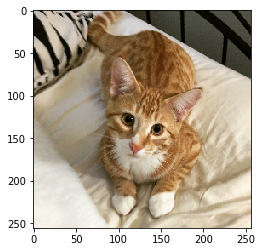

(256, 256, 3)


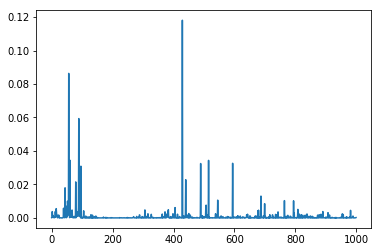

random input pred  tensor(429)


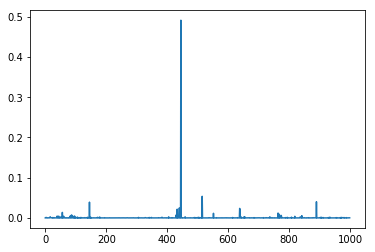

image input pred  tensor(445)


In [4]:
image = io.imread('image_cat.jpg')
# plt.imshow(image)
# plt.show()
# print(image.shape)
image = transform.resize(image, (256, 256), preserve_range=True).astype(np.uint8)
image.shape
plt.imshow(image)
plt.show()
print(image.shape)


image = image / 255
image = image*2 - 1
# f = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                  std=[0.229, 0.224, 0.225])

# input_image = f(torch.tensor(image).permute(2,0,1)).unsqueeze(0).float()
input_image = torch.tensor(image).permute(2,0,1).unsqueeze(0).float()

output1 = model(torch.rand(1,3,256,256))
output2 = model(input_image)

plt.plot(torch.softmax(output1, dim=-1).squeeze().detach())
plt.show()
print('random input pred ', output1.argmax())
plt.plot(torch.softmax(output2, dim=-1).squeeze().detach())
plt.show()
print('image input pred ', output2.argmax())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


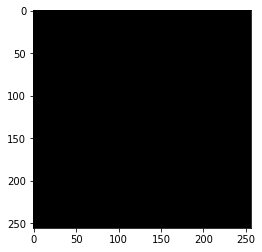

In [5]:
input1 = torch.rand(1,3,256,256)
relevance = lrp.relprop(input1)
plt.imshow(relevance.squeeze().permute(1,2,0))

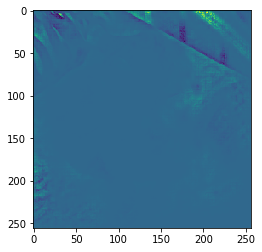

In [6]:
input2 = input_image
relevance = lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,0])

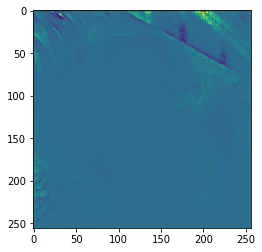

In [7]:
input2 = input_image
relevance = lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,1])

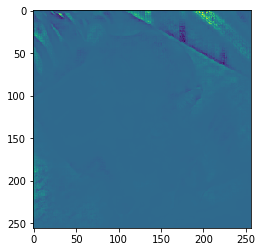

In [8]:
input2 = input_image
relevance = lrp.relprop(input2)
plt.imshow(relevance.squeeze().permute(1,2,0)[:,:,2])

# Identity resnet

In [21]:
def add_func(a,b):
    return a+b

In [39]:
class Madd_func(torch.autograd.Function):

    @staticmethod
    def forward(ctx, a, b):
        ctx.a = a.clone()
        ctx.b = b.clone()
        return a+b
    @staticmethod
    def backward(ctx, R):
        ctx.a.requires_grad_(True)
        ctx.b.requires_grad_(True)
        with torch.enable_grad():
            Z = ctx.a + ctx.b
            S = R/Z
#         import ipdb; ipdb.set_trace()
            Z.backward(S)
        return ctx.a*ctx.a.grad,  ctx.b*ctx.b.grad

In [44]:
a = torch.rand(1, requires_grad=True)
b = torch.rand(1, requires_grad=True)
c = Madd_func.apply(a, b)
c.backward(torch.tensor([10.]))
print(a, a.grad)
print(b, b.grad)

tensor([0.7731], requires_grad=True) tensor([9.0989])
tensor([0.0766], requires_grad=True) tensor([0.9011])
